In [1]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize
import unidecode
import seaborn as sns 

In [2]:
nlp = spacy.load('fr_core_news_lg')

In [3]:
nlp.max_length = 2000000

In [4]:
coef_fabula = pd.read_csv(r'results_svm/coefs_1000_fabula.csv', index_col='Unnamed: 0')

In [5]:
coef_fabula.sort_values(by = 'coefs', inplace=True)

In [6]:
len(coef_fabula)

1000

In [7]:
coef_canon_df = coef_fabula[:300]

In [8]:
coef_non_canon_df = coef_fabula[700:]

In [9]:
def clean_text(txt):
    txt_res = normalize("NFKD", txt.replace('\xa0', ' '))
    txt_res = txt_res.replace('\\xa0', '')
    return txt_res

In [10]:
coef_fabula

,coefs
avoir,-0.386128
m.,-0.343768
pâle,-0.329588
joie,-0.312983
qui,-0.306990
...,...
difficile,0.312661
noir,0.316151
ciel,0.327821
lequel,0.347292


In [11]:
test = coef_fabula.loc[coef_fabula.index == 'avoir']

In [12]:
type(test.values[0][0])

numpy.float64

### Try approche tous les coefs 
### Sinon 300 de coefs canon et coefs non-canon

In [24]:
def get_chunks_scores(path, df_coef, n):
    score = 0
    list_lemma = []
    str_base = ' '
    
    with open(path, encoding="utf8") as file:
        txt_brut = file.readlines()
        txt_str = str_base.join(txt_brut)
        txt_cleaned = clean_text(txt_str.lower())
    docs = nlp(txt_cleaned)
    for token in docs:
        list_lemma.append(token.lemma_)
    list_chunks = chunkise(list_lemma, n)
    return compute_score(list_chunks, df_coef)

In [14]:
def chunkise(list_token, n):
    list_chunks = []
    for i in range(0, len(list_token)-n, n):
        list_chunks.append(list_token[i:i+n])
    return list_chunks

In [15]:
def compute_score(list_chunks, df_coef):
    list_scores = []
    for chunk in list_chunks:
        score = 0
        for lemma in chunk:
            if lemma in list(df_coef.index):
                temp_score = coef_fabula.loc[coef_fabula.index == lemma]
                score += temp_score.values[0][0]
        list_scores.append(score)
    return list_scores

In [48]:
df_main = pd.DataFrame()


In [49]:
df_main

""


In [50]:
df_main['doc_name'] = [1,2,3]

In [51]:
df_main.loc()

,doc_name
0,1
1,2
2,3


In [52]:
df_main.loc['hehe'] = [4,2,3]

ValueError: cannot set a row with mismatched columns

In [54]:
def signal_canon(path_name, n_token_per_chunk, df_coef):
    
    df_main = pd.DataFrame()

    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        print(doc_name)
        
        list_scores = get_chunks_scores(doc, df_coef, n_token_per_chunk)
        
        df_main[doc_name] = pd.Series(list_scores)
    
    return df_main.fillna(0)


In [17]:
n_token_per_chunk = 500

In [18]:
path_name = r'corpus_test/*.txt'

In [75]:
df_scores = signal_canon(path_name, n_token_per_chunk, coef_fabula)

1852_Carraud-Zulma-Tourangin-Mme_La-petite-Jeanne
1884_Huysmans-Joris-Karl_a-rebours


In [76]:
df_scores

,1852_Carraud-Zulma-Tourangin-Mme_La-petite-Jeanne,1884_Huysmans-Joris-Karl_a-rebours
0,3.192060,7.662666
1,0.098367,9.960483
2,-10.639001,6.193939
3,-5.259580,7.755921
4,-10.118407,7.175688
...,...,...
125,-1.064131,7.941482
126,-2.816453,4.234666
127,-3.399378,7.351104
128,-6.664726,0.210655


In [74]:
df_scores['1852_Carraud-Zulma-Tourangin-Mme_La-petite-Jeanne'].mean()

-1.705352961221723

In [73]:
df_scores['1884_Huysmans-Joris-Karl_a-rebours'].mean()

5.615521863682203

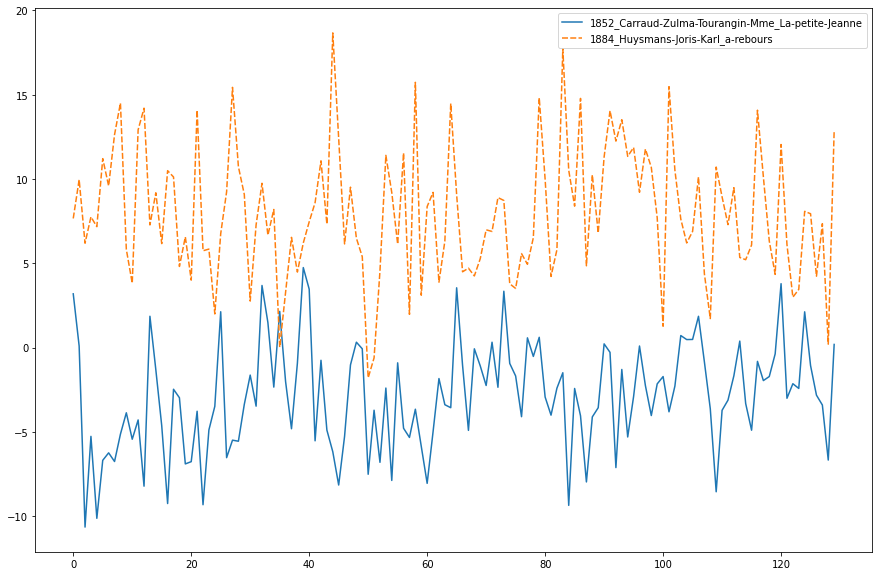

In [77]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)
